In [50]:
pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 132.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.3
    Uninstalling transformers-4.52.3:
      Successfully uninstalled transformers-4.52.3


# Persiapan Library dan lain lain

In [1]:
pip install transformers

In [2]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00


In [22]:
# Standar Library
import os
import re
import string
import urllib.request

# Data Manipulation
import numpy as np
import pandas as pd

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# NLP Preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Deep Learning (Keras)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Transformers & HuggingFace Datasets
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from datasets import load_dataset, Dataset

# Progress Bar
from tqdm import tqdm

from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np
import shutil
from transformers import TrainerCallback
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Inisialisasi Data

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRXPL1O2lmIeB6O9YE2wPGSBrFiGAcU2Wst_ltvYrc5lYxN5tQqxEdKjrRpxPvbrgP1atk0gDlGZVP3/pub?output=csv')

In [3]:
df

,video_id,author,text,manual label,published,likeCount
0,02_WTfYvQiE,@MalakaProjectid,"Malakan, menurut kalian Danantara lebih banyak...",NaN,2025-02-19T09:41:30Z,2076
1,02_WTfYvQiE,@siswoyohardjono2088,Mumet kondisi skrg,NaN,2025-06-03T12:49:44Z,0
2,02_WTfYvQiE,@pandurachmatika5341,analogi pernikahan dengan papa dana itu agak k...,NaN,2025-06-01T13:05:30Z,0
3,02_WTfYvQiE,@bayusyahputra7540,"Dalam waktu kedepan tak lama lg, akan muncul b...",NaN,2025-06-01T06:29:15Z,0
4,02_WTfYvQiE,@user-ng5qp9ww9x,Opportunity apa ya bang?,NaN,2025-05-31T09:12:12Z,0
...,...,...,...,...,...,...
40004,moZ_O2r0g6o,@vektor_forex,Asing beli 🚫\nDanantara beli ✅,NaN,2025-03-08T06:18:35Z,1
40005,moZ_O2r0g6o,@asepigun,Ini Endgame of Indonesia..,NaN,2025-03-08T06:14:37Z,156
40006,moZ_O2r0g6o,@AliceChGasclip,pak prabs ternyata pengikut andry hakim,NaN,2025-03-08T06:13:59Z,14
40007,moZ_O2r0g6o,@palmtree_,"Middle class tinggal 30% saja. Menurut NARASI,...",NaN,2025-03-08T06:13:10Z,21


# Bersihkan dan PreProses data

In [4]:
# Tahap 1: Lowercase semua teks
df['cleaned'] = df['text'].astype(str).str.lower()

# Tahap 2: Hapus URL
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))

# Tahap 3: Hapus emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emotikon wajah
        u"\U0001F300-\U0001F5FF"  # simbol & pictogram
        u"\U0001F680-\U0001F6FF"  # transportasi & simbol
        u"\U0001F1E0-\U0001F1FF"  # bendera
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['cleaned'] = df['cleaned'].apply(remove_emoji)

# Tahap 4: Hapus tanda baca & angka
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Tahap 5: Hapus spasi berlebih
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())


In [5]:
stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['cleaned_nostop'] = df['cleaned'].apply(remove_stopwords)

In [6]:
# Create a boolean mask indicating rows where 'cleaned_nostop' is an empty string
mask = df['cleaned_nostop'].apply(lambda x: len(x) == 0)

# Use the mask to drop the rows where 'cleaned_nostop' is empty
df = df[~mask].copy()

Sanity Check

In [7]:
df.isna().sum()

,0
video_id,0
author,10
text,4
manual label,39344
published,0
likeCount,0
cleaned,0
cleaned_nostop,0


In [8]:
df.sample(5,random_state=6)

,video_id,author,text,manual label,published,likeCount,cleaned,cleaned_nostop
5761,Tl6fDFA4xNI,@omjanglan3775,91.2 % dari seluruh rakyat Indonesia optimis ...,NaN,2025-03-06T02:49:21Z,0,dari seluruh rakyat indonesia optimis kpd dana...,rakyat indonesia optimis kpd danantara dikorup...
6850,Tl6fDFA4xNI,@itjem,"Takutnya focus investasinya adalah ikn, hiliri...",NaN,2025-03-01T20:54:00Z,0,takutnya focus investasinya adalah ikn hiliris...,takutnya focus investasinya ikn hilirisasi kep...
23177,ppCMZY1vdAE,@yogiichsan3909,ya jelas gelap kacamata item lu dibuka dulu woi,NaN,2025-03-06T08:51:03Z,0,ya jelas gelap kacamata item lu dibuka dulu woi,ya gelap kacamata item lu dibuka woi
25813,q-xMA8LbwoM,@ihsan.l9375,14.000 Triliun dari valuasi semua asset dan yg...,NaN,2025-03-17T22:05:08Z,0,triliun dari valuasi semua asset dan yg terdep...,triliun valuasi asset yg terdepresiasi parah d...
2206,02_WTfYvQiE,@pandapayung,aspek peluang pertumbuhan Danantara setiap per...,NaN,2025-02-21T06:18:01Z,0,aspek peluang pertumbuhan danantara setiap per...,aspek peluang pertumbuhan danantara persen ber...


# pisahkan data

In [9]:
df_use = df[['text', 'manual label', 'cleaned_nostop']].copy()

In [10]:
df_fine_tune = df_use[df_use['manual label'].notna()].copy()

In [27]:
df_use.to_csv('dataTahap2.csv')

## Hasil manual label

In [11]:
#Hasil manual label
df_fine_tune['manual label'].value_counts()

,count
manual label,
0.0,112
1.0,103
2.0,85


### Beberapa contoh ilustrasinya

In [12]:
pd.set_option('display.max_colwidth', None)
df_fine_tune[df_fine_tune['manual label'] == 0].sample(10, random_state = 42)

,text,manual label,cleaned_nostop
11941,Sebelum pak Feri ngomong sy menduga dah ketahuan menurut sy dia perwakilan asing,0.0,feri ngomong sy menduga dah ketahuan sy perwakilan asing
13577,"Seluruh Rakyat Indonesia , Dari Sabang Sampai Merauke ,,,,,, Mendukung Penuh DANANTARA , Untuk Kesejahteraan Seluruh Rakyat Indonesia ,,, Menuju Indonesia Maju ,,,,,,,,,, Amin Amin Amin",0.0,rakyat indonesia sabang merauke mendukung penuh danantara kesejahteraan rakyat indonesia indonesia maju amin amin amin
1614,"Buat yg koar"" Danaantara gak ada pengawasan, audit, dll..nih : Karena sifat lembaga seperti danaantara itu SWF, Menurut International Working Group of Sovereign Wealth Funds (IWG) (2008) terdapat 3 tipe SWF yaitu\n1) SWF yang dibentuk/didirikan dengan identitas atau badan hukum yang terpisah, dengan kapasitas penuh untuk melakukan kegiatan dan diatur oleh Undang-undang khusus (contoh Kuwait, Korea Selatan, Qatar dan United Arab Emirates/Abu Dhabi Investment Authority/ADIA).\n2) SWF yang berbentuk perusahaan atau badan usaha milik negara (contoh Temasek dan Government of Singapore Investment Corporation/GIC dari Singapura, atau China Investment Corporation/CIC dari China) yang tunduk pada UU tentang perusahaan dan juga tunduk pada UU tentang SWF apabila ada.\n3) SWF yang berbentuk sekumpulan aset tanpa adanya atau dibentuknya identitas atau badan hukum tersendiri. Kumpulan aset tersebut bisa dimiliki langsung oleh pemerintah atau bisa juga dimiliki oleh bank sentral contohnya Botswana, Canada/Alberta, Chile dan Norwegia. (sumbernya dri DJKN)",0.0,yg koar danaantara gak pengawasan audit dllnih sifat lembaga danaantara swf international working group of sovereign wealth funds iwg tipe swf swf dibentukdidirikan identitas badan hukum terpisah kapasitas penuh kegiatan diatur undangundang khusus contoh kuwait korea selatan qatar united arab emiratesabu dhabi investment authorityadia swf berbentuk perusahaan badan usaha milik negara contoh temasek government of singapore investment corporationgic singapura china investment corporationcic china tunduk uu perusahaan tunduk uu swf swf berbentuk sekumpulan aset dibentuknya identitas badan hukum tersendiri kumpulan aset dimiliki langsung pemerintah dimiliki bank sentral contohnya botswana canadaalberta chile norwegia sumbernya dri djkn
12197,"***Bersama Presiden Prabowo Subianto ,Indonesia akan bertambah Maju Adil dan Makmur _Aamiin _ 👍👍👍",0.0,presiden prabowo subianto indonesia bertambah maju adil makmur aamiin
11945,Pak ferry sedang membangun opini yg MENYESATKAN...\nhingga pesimis trhadap kebijakan JENIUS INI..DANANTARA...\nHURRRAAAA...,0.0,ferry membangun opini yg menyesatkan pesimis trhadap kebijakan jenius inidanantara hurrraaaa
16834,"Gua lebih liat Ray Dalio dan Jeffrey Sachs sih keren juga kita bisa tarik mereka, optimis gua",0.0,gua liat ray dalio jeffrey sachs sih keren tarik optimis gua
8329,Bagaimana klo Pak Parbowo bekerja sama dgn Pak Ahok telah terbukti melakukan yg terbaik untuk negri ini malah gak dipake karena takut dgn kejujuran .... Pak Ahok jika didukung mampu dan keberanian rela berkorban untuk rakyat Indonesia ❤❤❤❤,0.0,klo parbowo dgn ahok terbukti yg terbaik negri gak dipake takut dgn kejujuran ahok didukung keberanian rela berkorban rakyat indonesia
3553,"Sy berdiri bersama orang2 yg optimis, berani salah, siap dg perubahan... kawal ..",0.0,sy berdiri orang yg optimis berani salah dg perubahan kawal
3478,"kalau yg pimpin Danantara ini si Ahok, baru lumayan 'agak' percaya deh. 😅",0.0,yg pimpin danantara si ahok lumayan percaya deh
12058,Diskusi ini sangat bagus sbg Masukan tapi kita percaya pda pak presiden bahwa dia jugak seorang ekonom,0.0,diskusi bagus sbg masukan percaya pda presiden jugak ekonom


In [13]:
pd.set_option('display.max_colwidth', None)
df_fine_tune[df_fine_tune['manual label'] == 1].sample(10, random_state = 42)

,text,manual label,cleaned_nostop
12227,Salah undang narasumber om🤦‍♂️,1.0,salah undang narasumber om
33351,Menunggu harga tiket pesawat ambon - makassar jadi 5ratus ribu,1.0,menunggu harga tiket pesawat ambon makassar ratus ribu
33064,"masalah prinsip di danantara itu bkn programnya, tetapi diketuanya, ini bkn masalah personal, ini realitanya, ketua danantara itu kedudukannya sebagai Menteri, ini yg membuat pasar tdk percata, bagaimana mungkin ketua danantara ipegang ole seorang regulator dan diserahkan jg sebagai operatőr... pasar tdk suka konisi ini....rubahlah ketuanya,jng yg mengemban tugas sebagai regulator jg",1.0,prinsip danantara bkn programnya diketuanya bkn personal realitanya ketua danantara kedudukannya menteri yg pasar tdk percata ketua danantara ipegang ole regulator diserahkan jg operatr pasar tdk suka konisi inirubahlah ketuanyajng yg mengemban tugas regulator jg
25753,"Ga expect pak Gema kok jadi pembawa pesan rezim juga… institusi negara aja gaboleh audit, isi nya orang yg punya power politik… transparansi nya dimana? Kalo ngomongin hukum juga, kita liat lagi prinsip dan asas legislatif drafting itu gimana? Dari awal aja pembentukan UU nya aja sudah malpraktik kok ngomongin “pasti” berhasil… optimis itu boleh, tapi banyak prosedural secara hukum itu ditabrak, sama kyk waktu pencalonan buat wapres nya dia yg terbaru ini ya buat kekasih nya yaitu letkol. Teddy….",1.0,ga expect gema pembawa pesan rezim institusi negara aja gaboleh audit isi nya orang yg power politik transparansi nya dimana kalo ngomongin hukum liat prinsip asas legislatif drafting gimana aja pembentukan uu nya aja malpraktik ngomongin berhasil optimis prosedural hukum ditabrak kyk pencalonan wapres nya yg terbaru ya kekasih nya letkol teddy
22140,"Mau bagaimanapun budaya korupsi sudah mengakar kuat bahkan mendarah daging. Palu sudah diketuk Kita harus tetap optimis Dinantara cuan besar tiap tahun, klu estimasi cuan 10% aja dapat 1400T, ikhlaskan aja dah 100T buat di korupsi mrk sisanya utk kesejahteraan rakyat.",1.0,budaya korupsi mengakar kuat mendarah daging palu diketuk optimis dinantara cuan klu estimasi cuan aja t ikhlaskan aja dah t korupsi mrk sisanya utk kesejahteraan rakyat
20587,😂❤. Terlalu optimistis nasibnya lebih tragis dari yang pesimis. Cuma yang realistis yang bisa tersenyum manis.,1.0,optimistis nasibnya tragis pesimis realistis tersenyum manis
35574,Sahkan dulu perampasan aset baru boleh,1.0,sahkan perampasan aset
24033,"Terima kasih Bung Dr Gema Goeyardi atas pencerahannya tentang Danantara. Sebagai seorang bukan pelaku bisnis dan latar belakang pendidikan non ekonomi, sharing ini amat berharga memperluas wawasan saya mencermati isu kekinian Indonesia khususnya bidang ekonomi mikro. Dikombinasi dengan sumber kanal YouTube lainnya, pandangan Bung Gema ini membantu saya mendeskripsikan setidaknya ada 3 kelompok tipologi sikap komunitas atas Danantara: skeptis, kritis dan fanatik. Sebagai peminat sejarah perkembangan peradaban, khususnya perkembangan kapasitas manusia/peradaban, peminat kajian 79 tahun pembangunan Indonesia dan berlatar belakang pendidikan/karir teknik; saya termasuk dalam kelompok kritis atas program Danantara. Analisis sy atas 79 tahun isu keindonesiaan yang ditulis dalam buku: ""Menguji 78 Tahun Pembangunan Kapasitas Bangsa"", memposisikan sy pada kelompok kritis. Dengan tinjauan isu keindonesiaan itu dalam 3 perspektif: (i) 9 fase kebangkitan peradaban Barat/modern, periode 1341 - 1925; (ii) benchmarking keberhasilan transformasi Tiongkok dan Korea Selatan dan (iii) krisis 1998; pada buku tersebut disimpulkan bahwa pemecahan isu tersebut tidak cukup dg solusi teknokratik, tetapi memerlukan solusi struktural. Yakni solusi terkait dg usaha peningkatan kapasitas manusia. Belajar pada keberhasilan transformasi Tiongkok dan Korea Selatan menjadi negara industri dari negara pertanian, solusi struktural memerlukan waktu 25 - 30 tahun. Keberhasilan itu karena ke-2 negara tersebut berhasil mengadopsi 9 pondasi keban

In [14]:
pd.set_option('display.max_colwidth', None)
df_fine_tune[df_fine_tune['manual label'] == 2].sample(10, random_state = 42)

,text,manual label,cleaned_nostop
39219,"Indonesia ga pernah punya track record yg bagus dan bersih kalau urusan duit gede... dan melihat bagaimana tata kelola BUMN dan pemerintahan selama ini, it will just be another mega corruption case in the future. Lihat aja Jiwasraya, Asabri, dan dapen2 lain...\npengelolaan BUMN dan pemerintahan kita ga pernah ada yg profesional, bahkan utk bank2 besar yg terkenal dan jd tulang punggung devisa negara. \nDaripada ngurusin cari duit yg belum jelas, mending presiden kalau benar2 serius mau membenahi negeri ini ngurusin yg bocor dulu.. rahasia umum kalau anggaran baik di pusat maupun daerah efektivitas dan efisiensinya rendah...\ntapi ya negeri ini dipimpin dan diisi para manusia dgn integritas rendah yang sedang sibuk rebutan kue...",2.0,indonesia ga track record yg bagus bersih urusan duit gede tata kelola bumn pemerintahan it will just be another mega corruption case in the future lihat aja jiwasraya asabri dapen pengelolaan bumn pemerintahan ga yg profesional utk bank yg terkenal jd tulang punggung devisa negara ngurusin cari duit yg mending presiden serius membenahi negeri ngurusin yg bocor rahasia anggaran pusat daerah efektivitas efisiensinya rendah ya negeri dipimpin diisi manusia dgn integritas rendah sibuk rebutan kue
9,Nekad betul prabowo ini..bnr2 nekad!,2.0,nekad prabowo inibnr nekad
34792,Mantafff ayo yg punya tabungan tarik semua,2.0,mantafff ayo yg tabungan tarik
7485,"Mau optimis tp hati ga bisa di bohongi...jadi pertanyaan...bagaimana bisa danantara mengklaim mengelola aset 14 rb T ? Bukan nya danantara hanya mengelola deviden2 dari bumn saja, Apakah danantara bisa mengintervensi BUmN2 yg di bawah nya? Trus fungsi kementrian bumn gmn?",2.0,optimis tp hati ga bohongijadi pertanyaanbagaimana danantara mengklaim mengelola aset rb t nya danantara mengelola deviden bumn danantara mengintervensi bumn yg nya trus fungsi kementrian bumn gmn
2274,"bang, kita tetap dengan kacamata optimis yah, semoga bagus hasilnya, tp bedanya apa pengelolaannya dibanding dengan dana investasi bpjs, dana pensiun, asabri, Jiwasraya dll? return dari dana dana itu apakah bagus sampe sekarang?",2.0,bang kacamata optimis yah semoga bagus hasilnya tp bedanya pengelolaannya dibanding dana investasi bpjs dana pensiun asabri jiwasraya dll return dana dana bagus sampe
39372,Pasti korupsi,2.0,korupsi
1420,Gimn mau optimis klo orang yg terlibat pernah kena skandal korupsi.,2.0,gimn optimis klo orang yg terlibat kena skandal korupsi
5087,Karna terlalu Gemuk butuh makanan yg banyak. Saat ini pura2 irit aja,2.0,karna gemuk butuh makanan yg pura irit aja
74,Danantara spiritnya adalah KERAKUSAN,2.0,danantara spiritnya kerakusan
34788,Tarik semua saja..krn pengawasnya Si Mulyono.,2.0,tarik sajakrn pengawasnya si mulyono


# Sedikit penyesuaian sebelum fine tune

In [15]:
df_fine_tune['label'] = df_fine_tune['manual label'].astype(int)

In [16]:
dataset = Dataset.from_pandas(df_fine_tune[['cleaned_nostop', 'label']].rename(columns={'cleaned_nostop': 'text'}))

In [17]:
# pisahkan data
train_df, test_df = train_test_split(
    df_fine_tune[['text', 'label']],
    test_size=0.2,
    stratify=df_fine_tune['label'],
    random_state=42
)

# Percobaan fine tune model dengan IndoBert

In [18]:
# Step 5: Convert to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
eval_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

# Step 6: Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-large-p1")

# Step 7: Tokenize datasets
def tokenize_fn(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=512)

train_ds = train_ds.map(tokenize_fn, batched=True)
eval_ds = eval_ds.map(tokenize_fn, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

In [19]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-large-p1",
    num_labels=3
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Step 1: Define compute_metrics
def compute_metrics(p):
    preds = p.predictions.argmax(axis=-1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Step 2: Custom callback to record logs
class SimpleLogger(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.eval_acc = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if 'loss' in logs:
                self.train_loss.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_loss.append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                self.eval_acc.append(logs['eval_accuracy'])

logger = SimpleLogger()

In [24]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results-indobert',
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[logger]
)

trainer.train()

<ipython-input-24-dfca14c2bba4>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: aryadhammaw_ (aryadhammaw_-institut-teknologi-bandung) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.165700
20,1.099500
30,1.021600
40,0.901300
50,0.822900
60,0.717800
70,0.523500
80,0.580500
90,0.513700
100,0.344100


TrainOutput(global_step=600, training_loss=0.14429490475566126, metrics={'train_runtime': 345.6718, 'train_samples_per_second': 13.886, 'train_steps_per_second': 1.736, 'total_flos': 4473285658214400.0, 'train_loss': 0.14429490475566126, 'epoch': 20.0})

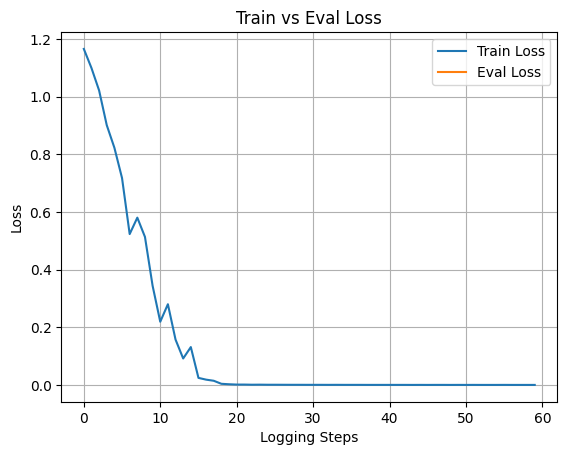

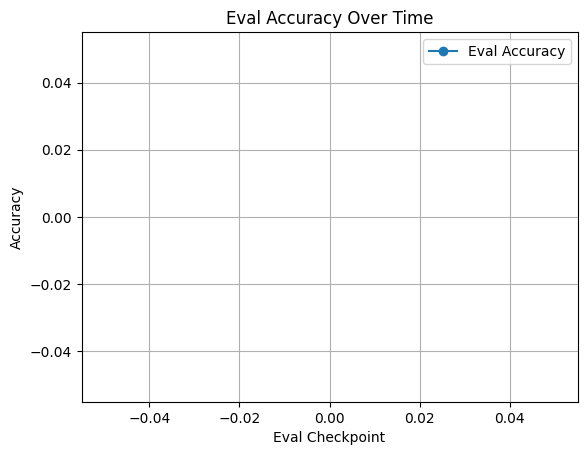

In [25]:
# Plot Losses
plt.plot(logger.train_loss, label="Train Loss")
plt.plot(logger.eval_loss, label="Eval Loss")
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.title("Train vs Eval Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.plot(logger.eval_acc, label="Eval Accuracy", marker='o')
plt.xlabel("Eval Checkpoint")
plt.ylabel("Accuracy")
plt.title("Eval Accuracy Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Simpan model

In [26]:
trainer.save_model("indobert-finetuned-youtube")
shutil.make_archive("indobert-finetuned-youtube", 'zip', "indobert-finetuned-youtube")

'/content/indobert-finetuned-youtube.zip'